In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn
from keras.layers import ZeroPadding2D
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

        

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
class google_net_cell(object):
    def __init__(self,image_width,image_height,channel):
        self.a = 0
        self.width = image_width
        self.height = image_height
        self.channel = channel
        self.filter_number = [channel,channel,channel,channel]
    def get_padding(self,tensor,shape):
        width = shape[0]
        height = shape[1]
        width2 = width // 2
        height2 = height // 2
        top = ((height - height2)//2)
        bottom = (height - height2 - top)
        left = ((width - width2) //2)
        right = (width - width2 - left)
        #print(right)
        paddings = [[top,bottom,],[left,right]]
        return ZeroPadding2D(paddings)(tensor)
    def conv(self,input_data):
        input_layer = tf.reshape(input_data, [-1, self.width, self.height, self.channel])
        conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=self.filter_number[0],
          kernel_size=[1, 1],
          padding="same",
          activation=tf.nn.relu)
        conv2_1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=self.filter_number[1],
          kernel_size=[1, 1],
          padding="same",
          activation=tf.nn.relu)
        conv2_2 = tf.layers.conv2d(
          inputs=conv2_1,
          filters=self.filter_number[1],
          kernel_size=[3, 3],
          padding="same",
          activation=tf.nn.relu)
        conv3_1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=self.filter_number[2],
          kernel_size=[1, 1],
          padding="same",
          activation=tf.nn.relu)
        conv3_2 = tf.layers.conv2d(
          inputs=conv3_1,
          filters=self.filter_number[2],
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        pool1 = tf.layers.average_pooling2d(inputs=input_layer, pool_size=[3, 3], strides=2)
        padding_pool = self.get_padding(pool1,[self.width,self.height])
        conv4 = tf.layers.conv2d(
          inputs=conv2_1,
          filters=self.filter_number[0],
          kernel_size=[1, 1],
          padding="same",
          activation=tf.nn.relu)
        return tf.concat([conv1,conv2_2,conv3_2,conv4],-1)

In [3]:
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

# Network Parameters
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)
image_width = 28
image_height = 28
cell = google_net_cell(28,28,1)
input_x = tf.placeholder("float", [None, image_width, image_height])
Y = tf.placeholder("float", [None, num_classes])

In [4]:
layer1 = cell.conv(input_x)

In [5]:
cell2 = google_net_cell(28,28,4)
layer2 = cell2.conv(layer1)
cell3 = google_net_cell(28,28,16)
layer3 = cell3.conv(layer2)
fatten = tf.reshape(layer3,[-1,28*28*64])
weights = {
    'w1': tf.Variable(tf.random_normal([28*28*64, num_hidden])),
    'w2': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([num_hidden])),
    'b2': tf.Variable(tf.random_normal([num_classes]))
}


In [6]:
vec1 = tf.nn.relu(tf.matmul(fatten, weights['w1']) + biases['b1'])
vec2 = tf.matmul(vec1, weights['w2']) + biases['b2']
# Define loss and optimizer
prediction = tf.nn.softmax(vec2)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=vec2, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [8]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
results = []

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, image_width, image_height))
        # Run optimization op (backprop)
        _ ,acc = sess.run([train_op,accuracy] ,feed_dict={input_x: batch_x, Y: batch_y})
        results.append(acc)
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={input_x: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, image_width, image_height))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", 
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

Step 1, Minibatch Loss= 31.9849, Training Accuracy= 0.156
Step 200, Minibatch Loss= 0.4835, Training Accuracy= 0.859
Step 400, Minibatch Loss= 0.4584, Training Accuracy= 0.859
Step 600, Minibatch Loss= 0.2016, Training Accuracy= 0.938
Step 800, Minibatch Loss= 0.1177, Training Accuracy= 0.945
Step 1000, Minibatch Loss= 0.1097, Training Accuracy= 0.961
Step 1200, Minibatch Loss= 0.0647, Training Accuracy= 0.984
Step 1400, Minibatch Loss= 0.0306, Training Accuracy= 0.992
Step 1600, Minibatch Loss= 0.1779, Training Accuracy= 0.961
Step 1800, Minibatch Loss= 0.0670, Training Accuracy= 0.977
Step 2000, Minibatch Loss= 0.1101, Training Accuracy= 0.961
Step 2200, Minibatch Loss= 0.0620, Training Accuracy= 0.984
Step 2400, Minibatch Loss= 0.0505, Training Accuracy= 0.984
Step 2600, Minibatch Loss= 0.0725, Training Accuracy= 0.977
Step 2800, Minibatch Loss= 0.0310, Training Accuracy= 0.992
Step 3000, Minibatch Loss= 0.0342, Training Accuracy= 0.992
Step 3200, Minibatch Loss= 0.0311, Training Ac

NameError: name 'X' is not defined

<function matplotlib.pyplot.show>

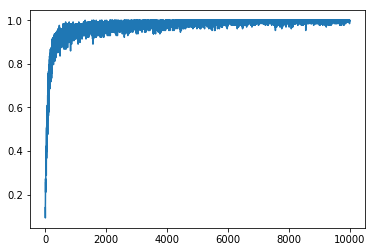

In [10]:
from matplotlib import pyplot as plt
plt.plot(range(training_steps),results)
plt.show